# Библиотеки

In [1]:
from time import time

import numpy as np
import pandas as pd

from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import matplotlib

np.random.seed(42)
%matplotlib inline 
%config InlineBackend.figure_format = 'svg'

In [2]:
markers = list(matplotlib.lines.Line2D.markers.keys())

# Реализация алогоритмов случайного леса и градиентного бустинга

In [3]:
class RandomForestMSE:
    def __init__(
            self, n_estimators, max_depth=None, feature_subsample_size=None,
            **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.
        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        if feature_subsample_size is None:
            self.feature_subsample_size = 1 / 3
        self.trees_params = trees_parameters
        # help params
        self.val_rmse_history = []
        self.train_rmse_history = []
        self.dt = []
        self.trees = []

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        y : numpy ndarray
            Array of size n_objects
        X_val : numpy ndarray
            Array of size n_val_objects, n_features
        y_val : numpy ndarray
            Array of size n_val_objects
        """
        if X_val is not None:
            self.val_rmse_history = []
        self.train_rmse_history = []
        self.dt = []
        t0 = time()
        n_objects = X.shape[0]
        self.trees = []
        if X_val is not None:
            pred_val = np.zeros_like(y_val)
        pred_train = np.zeros_like(y)
        for i in range(1, self.n_estimators + 1):
            tree = DecisionTreeRegressor(max_depth=self.max_depth, max_features=self.feature_subsample_size,
                                         **self.trees_params)
            # random subsample
            idx = np.random.randint(0, n_objects, n_objects)

            # train model
            tree.fit(X[idx], y[idx])
            self.trees.append(tree)
            self.dt.append(time() - t0)
            # val score
            if X_val is not None:
                if i == 1:
                    pred_val += tree.predict(X_val)
                else:
                    pred_val *= (i - 1) / i
                    pred_val += tree.predict(X_val) / i
                self.val_rmse_history.append(
                    np.sqrt(np.mean(np.square(pred_val - y_val)))
                )
            # train score
            if i == 1:
                pred_train += tree.predict(X)
            else:
                pred_train *= (i - 1) / i
                pred_train += tree.predict(X) / i
            self.train_rmse_history.append(
                np.sqrt(np.mean(np.square(pred_train - y)))
            )
            
    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        pred = np.zeros(X.shape[0])
        for tree in self.trees:
            pred += tree.predict(X) / len(self.trees)
        return pred 


class GradientBoostingMSE:
    def __init__(
            self, n_estimators, learning_rate=0.1, max_depth=5, feature_subsample_size=None,
            **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.
        learning_rate : float
            Use alpha * learning_rate instead of alpha
        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        if feature_subsample_size is None:
            self.feature_subsample_size = 1 / 3
        self.trees_params = trees_parameters
        # help params
        self.val_rmse_history = []
        self.train_rmse_history = []
        self.dt = []
        self.trees = []
        self.w = []

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        y : numpy ndarray
            Array of size n_objects
        """
        if X_val is not None:
            self.val_rmse_history = []
        self.train_rmse_history = []
        self.dt = []
        t0 = time()
        n_objects = X.shape[0]
        self.trees = []
        self.w = []
        z = np.zeros_like(y)  # train predict
        if X_val is not None:
            pred_val = np.zeros_like(y_val)
        for i in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth=self.max_depth, max_features=self.feature_subsample_size,
                                         **self.trees_params)

            # random subsample
            idx = np.random.randint(0, n_objects, n_objects)

            if i == 0:  # initial approximation
                tree.fit(X[idx], y[idx])
                self.dt.append(time() - t0)
                z += tree.predict(X)
                self.trees.append(tree)
                self.w.append(1)
                # val score
                if X_val is not None:
                    pred_val += self.w[-1] * tree.predict(X_val)

                    self.val_rmse_history.append(
                        np.sqrt(np.mean(np.square(pred_val - y_val)))
                    )
                # train score
                self.train_rmse_history.append(
                    np.sqrt(np.mean(np.square(z - y)))
                )
                continue
            s = z[idx] - y[idx]  # grad_z mse(y, z)
            tree.fit(X[idx], s)
            self.dt.append(time() - t0)
            preds = tree.predict(X)
            res = minimize_scalar(lambda w, z, preds: np.mean(np.square(z + w * preds - y)), args=(z, preds))
            self.w.append(self.learning_rate * res.x)
            z += self.w[-1] * preds

            self.trees.append(tree)
            # val score
            if X_val is not None:
                pred_val += self.w[-1] * tree.predict(X_val)

                self.val_rmse_history.append(
                    np.sqrt(np.mean(np.square(pred_val - y_val)))
                )
            # train score
            self.train_rmse_history.append(
                np.sqrt(np.mean(np.square(z - y)))
            )

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        pred = np.zeros(X.shape[0])
        for tree, w in zip(self.trees, self.w):
            pred += tree.predict(X) * w
        return pred

# Проверка правильности работы алгоритма

In [4]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=10000, n_features=15, n_informative=10, random_state=1024)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

model_rf = RandomForestMSE(n_estimators=100, max_depth=5)
model_gb = GradientBoostingMSE(n_estimators=100, max_depth=5)

model_rf.fit(X_train, y_train, X_valid, y_valid)
model_gb.fit(X_train, y_train, X_valid, y_valid)

In [5]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
skl_rf = RandomForestRegressor(n_estimators=100, max_depth=5, max_samples=1-1/np.e, max_features=1/3, random_state=42)
skl_rf.fit(X_train, y_train)
pred = skl_rf.predict(X_valid)
np.sqrt(np.mean(np.square(pred - y_valid)))

93.51094466387515

In [6]:
skl_gb = GradientBoostingRegressor(n_estimators=100, max_depth=5, max_features=1/3, subsample=1-1/np.e, random_state=42)
skl_gb.fit(X_train, y_train)
pred = skl_gb.predict(X_valid)
np.sqrt(np.mean(np.square(pred - y_valid)))

28.875529930350442

In [7]:
m = RandomForestMSE(n_estimators=100, max_depth=5)
m.fit(X_train, y_train)
pred = m.predict(X_valid)
np.sqrt(np.mean(np.square(pred - y_valid)))

94.12322414566728

In [8]:
m = GradientBoostingMSE(n_estimators=100, max_depth=5)
m.fit(X_train, y_train)
pred = m.predict(X_valid)
np.sqrt(np.mean(np.square(pred - y_valid)))

64.48412990012416

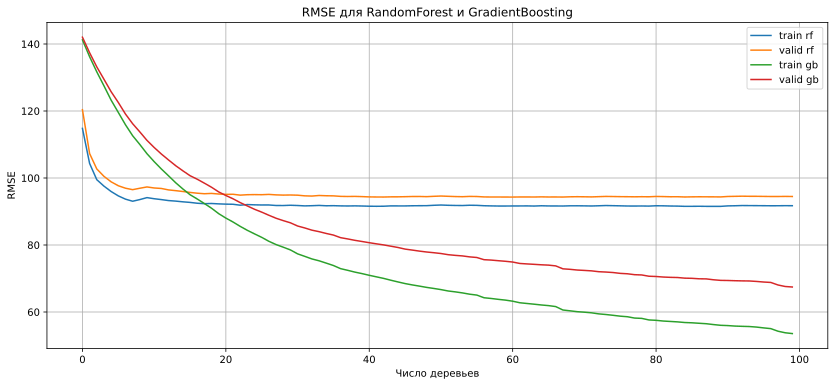

In [9]:
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(model_rf.train_rmse_history, label='train rf')
plt.plot(model_rf.val_rmse_history, label='valid rf')
plt.plot(model_gb.train_rmse_history, label='train gb')
plt.plot(model_gb.val_rmse_history, label='valid gb')
plt.title('RMSE для RandomForest и GradientBoosting')
plt.ylabel('RMSE')
plt.xlabel('Число деревьев')
plt.legend()
plt.grid()
plt.savefig('check.svg')
plt.show()

# Загрузка данных

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
df = pd.read_csv('/content/drive/MyDrive/tmp/prac/kc_house_data.csv')

In [12]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [13]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [14]:
features = list(df.columns[3:])
target = 'price'

In [15]:
df['year'] = pd.to_datetime(df['date']).apply(lambda x: x.year)
df['month'] = pd.to_datetime(df['date']).apply(lambda x: x.month)
df['day'] = pd.to_datetime(df['date']).apply(lambda x: x.day)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [16]:
features += ['year', 'month']
cat_features = ['zipcode', 'year', 'month']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.3, random_state=42)

In [18]:
encoder = OneHotEncoder()
tmp = pd.DataFrame.sparse.from_spmatrix(encoder.fit_transform(X_train[cat_features]))
tmp.index = X_train.index
X_train = X_train.drop(columns=cat_features)
X_train = pd.concat((X_train, tmp), axis=1)

In [19]:
tmp = pd.DataFrame.sparse.from_spmatrix(encoder.transform(X_test[cat_features]))
tmp.index = X_test.index
X_test = X_test.drop(columns=cat_features)
X_test = pd.concat((X_test, tmp), axis=1)

In [20]:
df.shape

(21613, 24)

In [21]:
"'', ''".join(df.columns)

"id'', ''date'', ''price'', ''bedrooms'', ''bathrooms'', ''sqft_living'', ''sqft_lot'', ''floors'', ''waterfront'', ''view'', ''condition'', ''grade'', ''sqft_above'', ''sqft_basement'', ''yr_built'', ''yr_renovated'', ''zipcode'', ''lat'', ''long'', ''sqft_living15'', ''sqft_lot15'', ''year'', ''month'', ''day"

# Эксперименты

## RF

In [22]:
rf_grid = {
    'max_depth': [1, 5, 15, None],
    'feature_subsample_size': [0.2, 0.6, 1]
}

In [23]:
rf_hist = {}
for md in rf_grid['max_depth']:
  for fss in rf_grid['feature_subsample_size']:
    print(f'-----[max_depth={md}, subsample_size={fss}]-----')
    model = RandomForestMSE(n_estimators=50, max_depth=md, feature_subsample_size=fss)
    t0 = time()
    model.fit(X_train.values, y_train.values, X_test.values, y_test.values)
    dt = time() - t0
    rf_hist[(md, fss)] = {'test_rmse': model.val_rmse_history, 'train_rmse': model.train_rmse_history, 'time': model.dt}
    print('time:', dt)

-----[max_depth=1, subsample_size=0.2]-----
time: 1.637507677078247
-----[max_depth=1, subsample_size=0.6]-----
time: 1.7353837490081787
-----[max_depth=1, subsample_size=1]-----
time: 1.3424830436706543
-----[max_depth=5, subsample_size=0.2]-----
time: 2.4818406105041504
-----[max_depth=5, subsample_size=0.6]-----
time: 4.957971811294556
-----[max_depth=5, subsample_size=1]-----
time: 1.9672741889953613
-----[max_depth=15, subsample_size=0.2]-----
time: 4.179497480392456
-----[max_depth=15, subsample_size=0.6]-----
time: 12.19066071510315
-----[max_depth=15, subsample_size=1]-----
time: 1.808182716369629
-----[max_depth=None, subsample_size=0.2]-----
time: 5.315946102142334
-----[max_depth=None, subsample_size=0.6]-----
time: 10.490847826004028
-----[max_depth=None, subsample_size=1]-----
time: 4.208649158477783


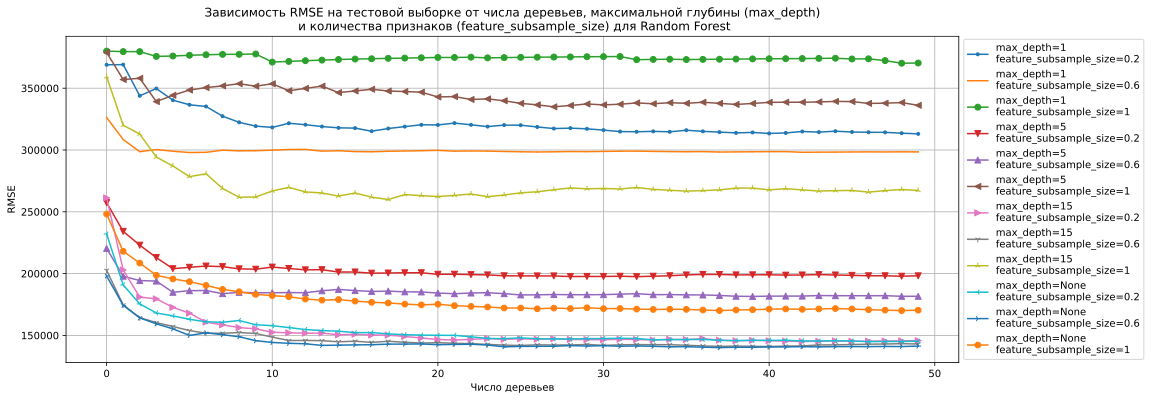

In [24]:
plt.figure(figsize=(16, 6), dpi=80)
for i, ((md, fss), d) in enumerate(rf_hist.items()):
  plt.plot(d['test_rmse'], label=f'max_depth={md}\nfeature_subsample_size={fss}', marker=markers[i])
plt.title('Зависимость RMSE на тестовой выборке от числа деревьев, максимальной глубины (max_depth)\n и количества признаков (feature_subsample_size) для Random Forest')
plt.ylabel('RMSE')
plt.xlabel('Число деревьев')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.savefig('/content/drive/MyDrive/tmp/prac/rf.svg')
plt.show()

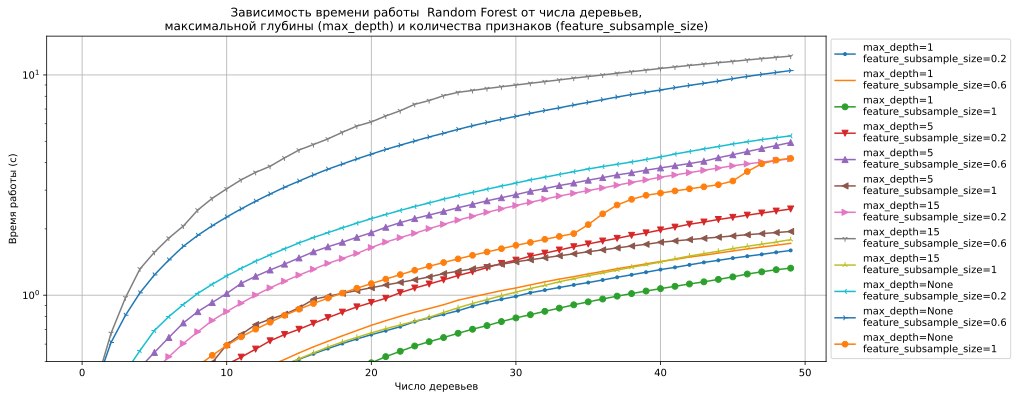

In [25]:
plt.figure(figsize=(14, 6), dpi=80)
for i, ((md, fss), d) in enumerate(rf_hist.items()):
  plt.plot(d['time'], label=f'max_depth={md}\nfeature_subsample_size={fss}', marker=markers[i])
plt.title('Зависимость времени работы  Random Forest от числа деревьев,\nмаксимальной глубины (max_depth) и количества признаков (feature_subsample_size)')
plt.ylabel('Время работы (c)')
plt.xlabel('Число деревьев')
plt.yscale('log')
plt.ylim((0.5, 15))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.savefig('/content/drive/MyDrive/tmp/prac/time-rf.svg')
plt.show()

## GB

In [26]:
gb_grid = {
    'max_depth': [1, 5, 15, None],
    'feature_subsample_size': [0.2, 0.6, 1],
    'learning_rate': [1e-2, 1e-1, 1]
}

In [27]:
gb_hist = {}
for md in gb_grid['max_depth']:
  for fss in gb_grid['feature_subsample_size']:
    for lr in gb_grid['learning_rate']:
      print(f'-----[max_depth={md}, subsample_size={fss}, learning_rate={lr:0.3f}]-----')
      model = GradientBoostingMSE(n_estimators=200, max_depth=md, learning_rate=lr, feature_subsample_size=fss)
      t0 = time()
      model.fit(X_train.values, y_train.values, X_test.values, y_test.values)
      dt = time() - t0
      gb_hist[(md, fss, lr)] = {'test_rmse': model.val_rmse_history, 'train_rmse': model.train_rmse_history, 'time': model.dt}
      print('time:', dt)

-----[max_depth=1, subsample_size=0.2, learning_rate=0.010]-----
time: 6.21345067024231
-----[max_depth=1, subsample_size=0.2, learning_rate=0.100]-----
time: 5.565166234970093
-----[max_depth=1, subsample_size=0.2, learning_rate=1.000]-----
time: 6.331173896789551
-----[max_depth=1, subsample_size=0.6, learning_rate=0.010]-----
time: 8.093369245529175
-----[max_depth=1, subsample_size=0.6, learning_rate=0.100]-----
time: 7.943639278411865
-----[max_depth=1, subsample_size=0.6, learning_rate=1.000]-----
time: 7.809849977493286
-----[max_depth=1, subsample_size=1, learning_rate=0.010]-----
time: 5.599081993103027
-----[max_depth=1, subsample_size=1, learning_rate=0.100]-----
time: 5.706301212310791
-----[max_depth=1, subsample_size=1, learning_rate=1.000]-----
time: 5.414044141769409
-----[max_depth=5, subsample_size=0.2, learning_rate=0.010]-----
time: 8.946359634399414
-----[max_depth=5, subsample_size=0.2, learning_rate=0.100]-----
time: 9.241599559783936
-----[max_depth=5, subsample

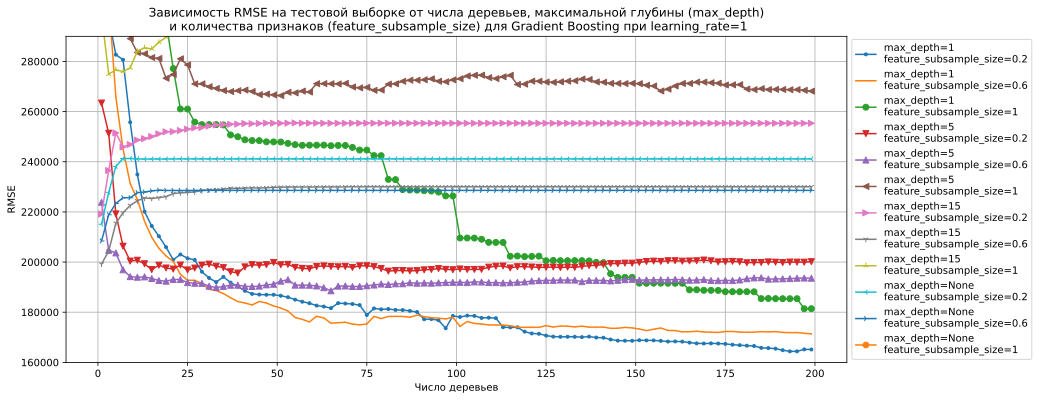

In [28]:
plt.figure(figsize=(14, 6), dpi=80)
for i, ((md, fss, lr), d) in enumerate(gb_hist.items()):
  if lr != 1:
    continue
  plt.plot(np.arange(1, 201, 2), d['test_rmse'][::2], label=f'max_depth={md}\nfeature_subsample_size={fss}', marker=markers[i//3])
plt.title('Зависимость RMSE на тестовой выборке от числа деревьев, максимальной глубины (max_depth)\n и количества признаков (feature_subsample_size) для Gradient Boosting при learning_rate=1')
plt.ylabel('RMSE')
plt.xlabel('Число деревьев')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.ylim((160000, 290000))
plt.savefig('/content/drive/MyDrive/tmp/prac/gb-lr1.svg')
plt.show()

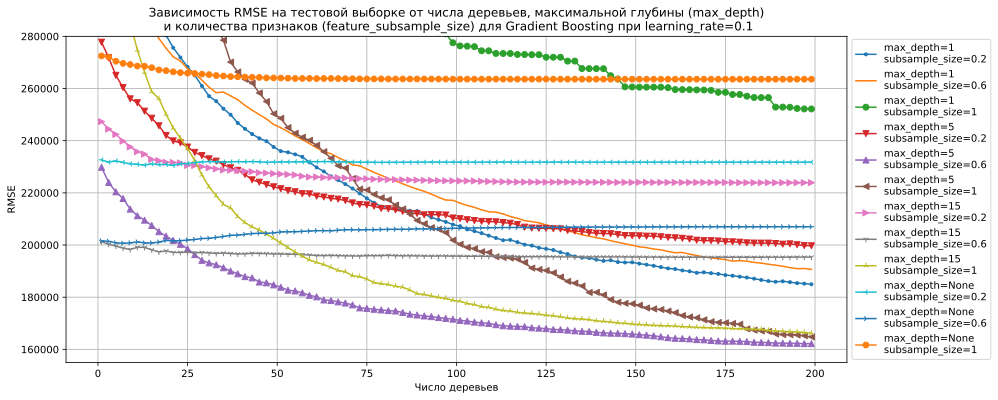

In [29]:
plt.figure(figsize=(14, 6), dpi=80)
for i, ((md, fss, lr), d) in enumerate(gb_hist.items()):
  if lr != 0.1:
    continue
  plt.plot(np.arange(1, 201, 2), d['test_rmse'][::2], label=f'max_depth={md}\nsubsample_size={fss}', marker=markers[i//3])

plt.title('Зависимость RMSE на тестовой выборке от числа деревьев, максимальной глубины (max_depth)\n и количества признаков (feature_subsample_size) для Gradient Boosting при learning_rate=0.1')
plt.ylabel('RMSE')
plt.xlabel('Число деревьев')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.ylim((155000, 280000))
plt.savefig('/content/drive/MyDrive/tmp/prac/gb-lr01.svg')
plt.show()

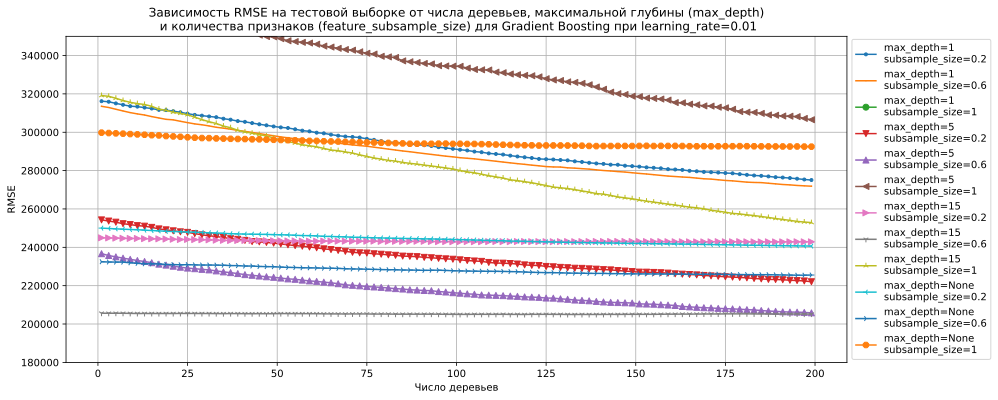

In [30]:
plt.figure(figsize=(14, 6), dpi=80)
for i, ((md, fss, lr), d) in enumerate(gb_hist.items()):
  if lr != 0.01:
    continue
  plt.plot(np.arange(1, 201, 2), d['test_rmse'][::2], label=f'max_depth={md}\nsubsample_size={fss}', marker=markers[i//3])
plt.title('Зависимость RMSE на тестовой выборке от числа деревьев, максимальной глубины (max_depth)\n и количества признаков (feature_subsample_size) для Gradient Boosting при learning_rate=0.01')
plt.ylabel('RMSE')
plt.xlabel('Число деревьев')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.ylim((180000, 350000))
plt.savefig('/content/drive/MyDrive/tmp/prac/gb-lr001.svg')
plt.show()

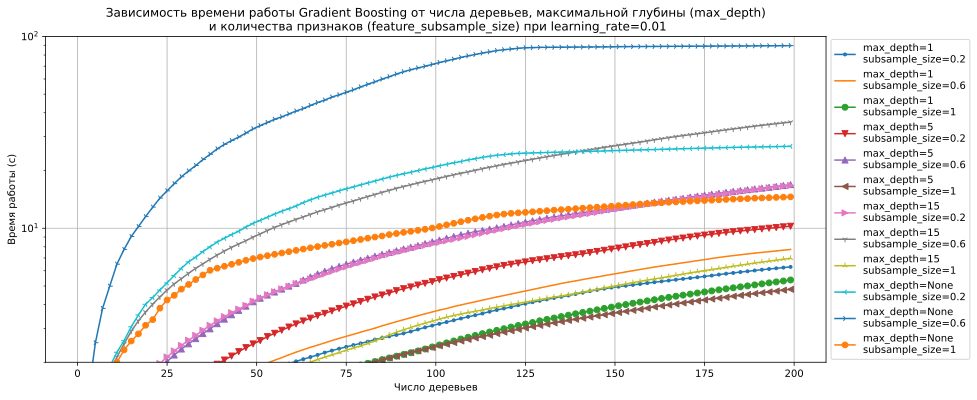

In [31]:
plt.figure(figsize=(14, 6), dpi=80)
for i, ((md, fss, lr), d) in enumerate(gb_hist.items()):
  if lr != 1:
    continue
  plt.plot(np.arange(1, 201, 2), d['time'][::2], label=f'max_depth={md}\nsubsample_size={fss}', marker=markers[i//3])
plt.title('Зависимость времени работы Gradient Boosting от числа деревьев, максимальной глубины (max_depth)\n и количества признаков (feature_subsample_size) при learning_rate=0.01')
plt.ylabel('Время работы (c)')
plt.xlabel('Число деревьев')
plt.yscale('log')
plt.ylim((2, 100))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.savefig('/content/drive/MyDrive/tmp/prac/time-gb-lr1.svg')
plt.show()

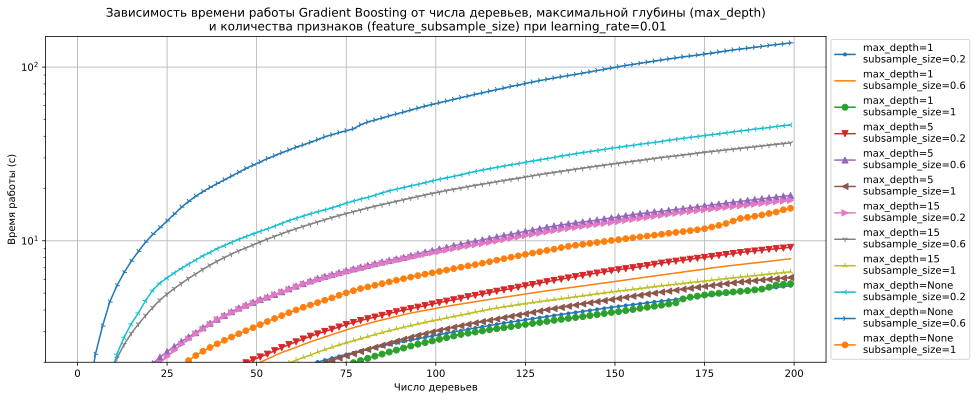

In [32]:
plt.figure(figsize=(14, 6), dpi=80)
for i, ((md, fss, lr), d) in enumerate(gb_hist.items()):
  if lr != 0.1:
    continue
  plt.plot(np.arange(1, 201, 2), d['time'][::2], label=f'max_depth={md}\nsubsample_size={fss}', marker=markers[i//3])
plt.title('Зависимость времени работы Gradient Boosting от числа деревьев, максимальной глубины (max_depth)\n и количества признаков (feature_subsample_size) при learning_rate=0.01')
plt.ylabel('Время работы (c)')
plt.xlabel('Число деревьев')
plt.yscale('log')
plt.ylim((2, 150))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.savefig('/content/drive/MyDrive/tmp/prac/time-gb-lr01.svg')
plt.show()

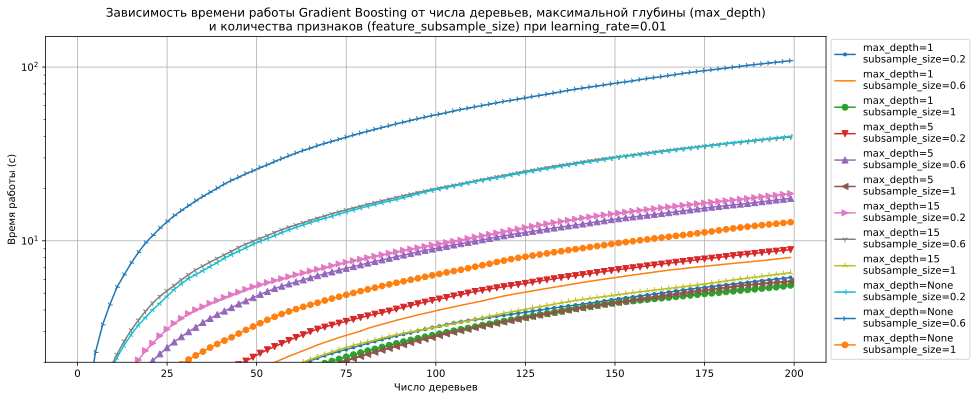

In [33]:
plt.figure(figsize=(14, 6), dpi=80)
for i, ((md, fss, lr), d) in enumerate(gb_hist.items()):
  if lr != 0.01:
    continue
  plt.plot(np.arange(1, 201, 2), d['time'][::2], label=f'max_depth={md}\nsubsample_size={fss}', marker=markers[i//3])
plt.title('Зависимость времени работы Gradient Boosting от числа деревьев, максимальной глубины (max_depth)\n и количества признаков (feature_subsample_size) при learning_rate=0.01')
plt.ylabel('Время работы (c)')
plt.xlabel('Число деревьев')
plt.yscale('log')
plt.ylim((2, 150))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.savefig('/content/drive/MyDrive/tmp/prac/time-gb-lr001.svg')
plt.show()